In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [10]:
import os
import shutil
import random
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image


In [4]:
# Step 1: upload the zip
from google.colab import files
uploaded = files.upload()  # Select XR_HUMERUS.zip from your PC


Saving XR_HUMERUS.zip to XR_HUMERUS.zip


In [9]:
xr_dir = "/content/XR_HUMERUS"   # <-- make sure this matches what you see in !ls
base_dir = "/content/Bone_Fracture_Project"




In [12]:
!unzip XR_HUMERUS.zip -d /content/XR_HUMERUS


Archive:  XR_HUMERUS.zip
   creating: /content/XR_HUMERUS/XR_HUMERUS/
   creating: /content/XR_HUMERUS/XR_HUMERUS/patient00051/
   creating: /content/XR_HUMERUS/XR_HUMERUS/patient00051/study1_positive/
  inflating: /content/XR_HUMERUS/XR_HUMERUS/patient00051/study1_positive/image1.png  
  inflating: /content/XR_HUMERUS/XR_HUMERUS/patient00051/study1_positive/image2.png  
   creating: /content/XR_HUMERUS/XR_HUMERUS/patient00058/
   creating: /content/XR_HUMERUS/XR_HUMERUS/patient00058/study1_negative/
  inflating: /content/XR_HUMERUS/XR_HUMERUS/patient00058/study1_negative/image1.png  
  inflating: /content/XR_HUMERUS/XR_HUMERUS/patient00058/study1_negative/image2.png  
   creating: /content/XR_HUMERUS/XR_HUMERUS/patient00077/
   creating: /content/XR_HUMERUS/XR_HUMERUS/patient00077/study1_negative/
  inflating: /content/XR_HUMERUS/XR_HUMERUS/patient00077/study1_negative/image1.png  
  inflating: /content/XR_HUMERUS/XR_HUMERUS/patient00077/study1_negative/image2.png  
   creating: /cont

In [13]:
!ls /content/XR_HUMERUS


XR_HUMERUS


In [14]:
# Delete the wrong folder first to avoid confusion
!rm -rf /content/XR_HUMERUS

# Unzip properly
!unzip XR_HUMERUS.zip -d /content/


Archive:  XR_HUMERUS.zip
   creating: /content/XR_HUMERUS/
   creating: /content/XR_HUMERUS/patient00051/
   creating: /content/XR_HUMERUS/patient00051/study1_positive/
  inflating: /content/XR_HUMERUS/patient00051/study1_positive/image1.png  
  inflating: /content/XR_HUMERUS/patient00051/study1_positive/image2.png  
   creating: /content/XR_HUMERUS/patient00058/
   creating: /content/XR_HUMERUS/patient00058/study1_negative/
  inflating: /content/XR_HUMERUS/patient00058/study1_negative/image1.png  
  inflating: /content/XR_HUMERUS/patient00058/study1_negative/image2.png  
   creating: /content/XR_HUMERUS/patient00077/
   creating: /content/XR_HUMERUS/patient00077/study1_negative/
  inflating: /content/XR_HUMERUS/patient00077/study1_negative/image1.png  
  inflating: /content/XR_HUMERUS/patient00077/study1_negative/image2.png  
   creating: /content/XR_HUMERUS/patient00119/
   creating: /content/XR_HUMERUS/patient00119/study1_negative/
  inflating: /content/XR_HUMERUS/patient00119/study

In [15]:
!ls /content/XR_HUMERUS


patient00051  patient02758  patient02876  patient02994	patient03112
patient00058  patient02759  patient02877  patient02995	patient03113
patient00077  patient02760  patient02878  patient02996	patient03114
patient00119  patient02761  patient02879  patient02997	patient03115
patient00147  patient02762  patient02880  patient02998	patient03116
patient00180  patient02763  patient02881  patient02999	patient03117
patient00246  patient02764  patient02882  patient03000	patient03118
patient00297  patient02765  patient02883  patient03001	patient03119
patient00363  patient02766  patient02884  patient03002	patient03120
patient00438  patient02767  patient02885  patient03003	patient03121
patient00462  patient02768  patient02886  patient03004	patient03122
patient00466  patient02769  patient02887  patient03005	patient03123
patient00560  patient02770  patient02888  patient03006	patient03124
patient00577  patient02771  patient02889  patient03007	patient03125
patient00631  patient02772  patient02890  patien

In [16]:
import os
import shutil
import random

xr_dir = "/content/XR_HUMERUS"   # your unzipped folder
base_dir = "/content/Bone_Fracture_Project"

# Create train/valid/test folders
for split in ["train", "valid", "test"]:
    for cls in ["fractured", "normal"]:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

# Shuffle patients
patients = [p for p in os.listdir(xr_dir) if os.path.isdir(os.path.join(xr_dir, p))]
random.shuffle(patients)

# Split: 70% train, 15% valid, 15% test
train_end = int(0.7 * len(patients))
valid_end = int(0.85 * len(patients))

train_patients = patients[:train_end]
valid_patients = patients[train_end:valid_end]
test_patients  = patients[valid_end:]

# Copy images into proper folders
def copy_images(patient_list, split):
    count = 0
    for patient in patient_list:
        patient_path = os.path.join(xr_dir, patient)
        for study in os.listdir(patient_path):
            study_path = os.path.join(patient_path, study)
            cls = "fractured" if "positive" in study.lower() else "normal"
            for img in os.listdir(study_path):
                if img.lower().endswith((".png", ".jpg", ".jpeg")):
                    src = os.path.join(study_path, img)
                    dst = os.path.join(base_dir, split, cls, f"{patient}_{img}")
                    shutil.copy(src, dst)
                    count += 1
    print(f"{count} images copied to {split} set")

copy_images(train_patients, "train")
copy_images(valid_patients, "valid")
copy_images(test_patients, "test")

print("✅ Dataset preprocessing complete")


903 images copied to train set
188 images copied to valid set
181 images copied to test set
✅ Dataset preprocessing complete


In [17]:
for split in ["train","valid","test"]:
    for cls in ["fractured","normal"]:
        path = os.path.join(base_dir, split, cls)
        print(f"{split}/{cls} → {len(os.listdir(path))} images")


train/fractured → 436 images
train/normal → 463 images
valid/fractured → 89 images
valid/normal → 99 images
test/fractured → 72 images
test/normal → 107 images


In [18]:
import tensorflow as tf

IMG_SIZE = 224
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(base_dir, "train"),
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(base_dir, "valid"),
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(base_dir, "test"),
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)


Found 899 files belonging to 2 classes.
Found 188 files belonging to 2 classes.
Found 179 files belonging to 2 classes.


In [19]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 301ms/step - accuracy: 0.5124 - loss: 0.9736 - val_accuracy: 0.6011 - val_loss: 0.6867
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.5764 - loss: 0.6718 - val_accuracy: 0.6277 - val_loss: 0.6524
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.6652 - loss: 0.6073 - val_accuracy: 0.6223 - val_loss: 0.7106
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.7603 - loss: 0.4686 - val_accuracy: 0.5957 - val_loss: 0.8054
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.8717 - loss: 0.3359 - val_accuracy: 0.5904 - val_loss: 1.1298
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.9115 - loss: 0.2237 - val_accuracy: 0.5904 - val_loss: 1.5038
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.9484 - loss: 0.1547 - val_accuracy: 0.5532 - val_loss: 1.6892
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.9536 - loss: 0.1173 - val_accuracy: 0

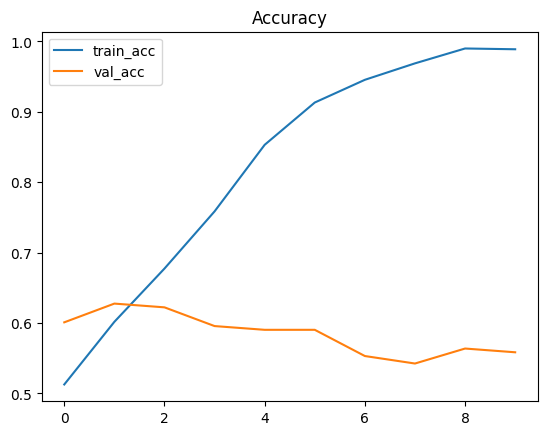

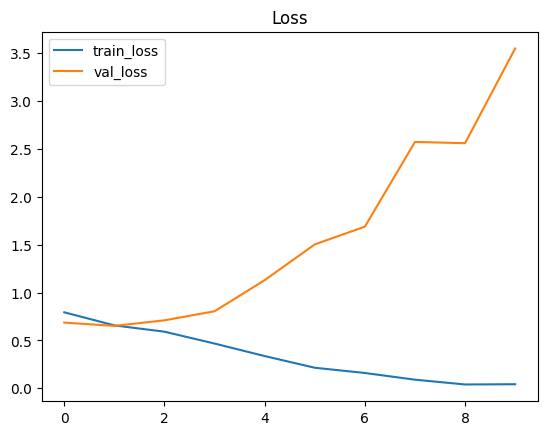

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Loss")
plt.show()


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Replace <image_name>.png with any image from your test folder
img_path = "/content/Bone_Fracture_Project/test/fractured/<image_name>.png"

img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = image.img_to_array(img)/255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)[0][0]
print("Predicted:", "FRACTURED" if pred>0.5 else "NORMAL")


In [22]:
!ls /content/Bone_Fracture_Project


test  train  valid


In [23]:
import os

test_fractured_dir = "/content/Bone_Fracture_Project/test/fractured"
images = os.listdir(test_fractured_dir)
print(images[:10])  # prints first 10 images


['patient02743_image1.png', 'patient02727_image3.png', 'patient02757_image1.png', 'patient02770_image1.png', 'patient02783_image1.png', 'patient02772_image3.png', 'patient02772_image1.png', 'patient02824_image2.png', 'patient02865_image2.png', 'patient02912_image1.png']


In [24]:
img_name = "patient02727_image3.png"
img_path = os.path.join(test_fractured_dir, img_name)
print(img_path)


/content/Bone_Fracture_Project/test/fractured/patient02727_image3.png


In [25]:
from tensorflow.keras.preprocessing import image
import numpy as np

IMG_SIZE = 224  # same as training

img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = image.img_to_array(img)/255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)[0][0]
print("Predicted:", "FRACTURED" if pred>0.5 else "NORMAL")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
Predicted: NORMAL


In [28]:
model_save_path = "/content/Bone_Fracture_Project/fracture_model.h5"
model.save(model_save_path)
print(f"Model saved at {model_save_path}")


Model saved at /content/Bone_Fracture_Project/fracture_model.h5


In [33]:
!git clone https://github.com/srujan-io/Fracture_Detection_Nexus.git
%cd Fracture_Detection_Nexus


Cloning into 'Fracture_Detection_Nexus'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (5/5), done.
/content/Fracture_Detection_Nexus


In [38]:
!ls /content



Bone_Fracture_Project	  sample_data  XR_HUMERUS.zip
Fracture_Detection_Nexus  XR_HUMERUS


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
